## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
text = "".join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# text = "".join(text)
# text = text.lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = dict(zip(tokens, range(len(tokens))))


# dict <char>:<index>
idx_to_token = dict(enumerate(tokens))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from random import sample
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
def get_batches(text, batch_size, length):
    '''
    Returns matrix with size [batch_size, length]
    Each line: random string in text splitted into chars and then converted into token indexes
    '''
    # Shuffle at the start of epoch
    all_positions = np.arange(len(text) - length + 1)
    np.random.shuffle(all_positions)
        
    for start_idx in range(0, len(all_positions), batch_size):
        end_idx = start_idx + batch_size
        
        start_positions = all_positions[start_idx:end_idx]
        end_positions = start_positions + length
        
        strings_idx = np.zeros((batch_size, length), dtype=int)
        for i, (str_start, str_end) in enumerate(zip(start_positions, end_positions)):
            string = text[str_start : str_end]
            strings_idx[i] = [token_to_idx[c] for c in string]
        yield strings_idx

In [12]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size, rnn_num_units):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, next_logits

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
MAX_ITERATION = 100

N_TOKENS = len(tokens)

BATCH_SIZE = 100

RNN_UNITS = 1000

EMB_SIZE = 200

def train_model(model, opt, max_iterations):
    loss_history = []
    for i, batch_idx in enumerate(get_batches(text, BATCH_SIZE, EMB_SIZE)):
        if i >= max_iterations:
            break

        batch_idx = torch.LongTensor(batch_idx)
        
        
        logp_seq, _ = model(batch_idx)

        predictions_logp = logp_seq[:, :-1].reshape(-1, N_TOKENS)
        actual_next_tokens = batch_idx[:, 1:].reshape(-1)

        loss = F.nll_loss(predictions_logp, actual_next_tokens)

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        loss_history.append(loss.data.numpy())

        clear_output(True)
        plt.figure(figsize=(10, 8))
        plt.title("Learning process loss history")
        plt.plot(loss_history)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.show()

    print(f'Current train loss: {loss_history[-1]}')

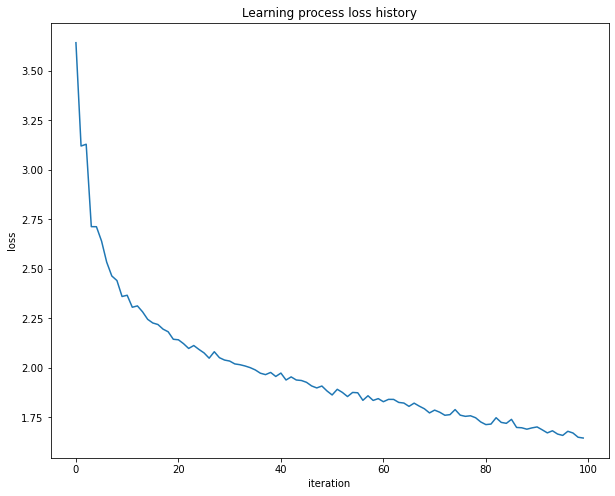

Current train loss: 1.6455925703048706


In [14]:
rnn_model = CharRNNLoop(len(tokens), EMB_SIZE, RNN_UNITS)
rnn_opt = torch.optim.Adam(rnn_model.parameters())

train_model(rnn_model, rnn_opt, 100)

In [15]:
def generate_sample(model, seed_phrase, max_length, temperature=1.0):
    '''    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    This model waits logits (not probabilities/log-probabilities) of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        model(torch.tensor([[x_sequence[:, i]]], dtype=torch.int64))
    
    #start generating
    for i in range(max_length - len(seed_phrase)):
        _, out = model(x_sequence)
        

        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0, -1]
        p_next = p_next.flatten()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [16]:
print(generate_sample(rnn_model, "hellow", 500, temperature=0.3))

hellow thes thee the strend where the self the pare the sore in the start the sees the with the the heart the so the ser my love prowirg the is the so the single sun the self the stall the sweet in my see have the world the such such against the reast the so songed that in the stall the see the with the steres the so the still the world and the shall dost the to the steat the sone eyes and thee she the beauty doth the stranter the self be the self live the seef art the see the start the steet th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [17]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size, rnn_num_units): # переделай начальные значения
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, next_logits

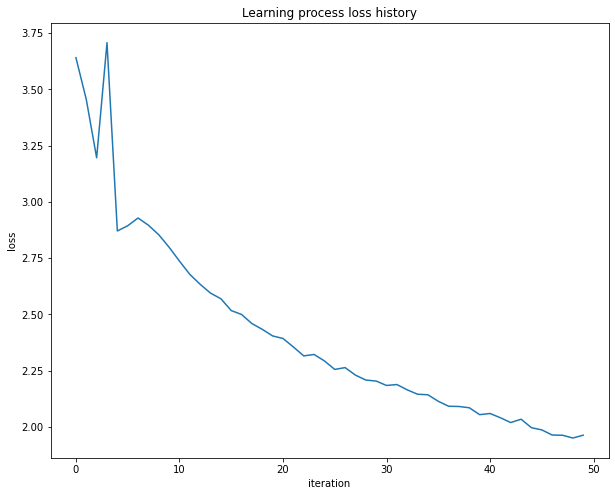

Current train loss: 1.9634958505630493


In [18]:
lstm_model = CharLSTMLoop(len(tokens), EMB_SIZE, RNN_UNITS)
opt = torch.optim.Adam(lstm_model.parameters())

train_model(lstm_model, opt, 50)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [19]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"Temprature = {temp}")
    print("____________________________________________________________________________________________________")
    print(generate_sample(lstm_model, "hellow", 500, temperature=temp))
    print("____________________________________________________________________________________________________")

Temprature = 0.1
____________________________________________________________________________________________________
hellow the the seare the seare the with the seare the seare the seart the seart the seare the the seart the the seare the seare the seart of the the me the the seare the seare the seart the the the seare the with the sould the the with the the seart of the with the will the the the seare the seart in the with the the seart the with the seare the the seare the seare the with the seare the the the seare the seare the seare the seare the seare thee the the seare the seare the seart the the with the
____________________________________________________________________________________________________
Temprature = 0.2
____________________________________________________________________________________________________
hellow the sore the so me the the with the thee the with the seart of the me the the beart the the me the the mare sour the erest in the there and the with the th

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [21]:
PATH = "/home/maksim/Документы/МФТИ/5sem/machine_learning/lab02_deep_learning/model"
torch.save(lstm_model.state_dict(), PATH)

load_model = CharLSTMLoop(len(tokens), EMB_SIZE, RNN_UNITS)
load_model.load_state_dict(torch.load(PATH))

print(generate_sample(load_model, " ", 500, temperature=0.5))

 thes heat in sall the io and seate, i thine thee and shat the ald my wore,
  shy forenour thy lofe thou but the beatile mute wime routh wher the the thee with the preence he fare the withe beare, and frime wine ene the enest the indour that meser sulle the al the the sowend the swert beast of mease thour mast love by all seeld as mast be to selle but there may and the with weall the sull sheare in the thee the pare winter and the sook the sone sellves the sormy be and thee,
  all here me will t


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)